# Feature engineering
## Import libraries

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from pathlib import Path
import tsfresh
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters, ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
import collections

In [2]:
# Read data
data = pd.read_csv('../FIT5149_A2_data/train_data_withlabels.csv')
data.rename(columns={"Unnamed: 0":"id"}, inplace= True)
data.head(100)

id   load  ac  ev  oven  wash  dryer  hourofday dayofweek    dif  \
0   105541  2.245   0   0     0     0      0          0       Sun  0.987   
1   105542  2.259   0   0     0     0      0          0       Sun  0.014   
2   105543  2.269   0   0     0     0      0          0       Sun  0.010   
3   105544  2.268   0   0     0     0      0          0       Sun -0.001   
4   105545  2.270   0   0     0     0      0          0       Sun  0.002   
5   105546  2.259   0   0     0     0      0          0       Sun -0.011   
6   105547  2.250   0   0     0     0      0          0       Sun -0.009   
7   105548  2.251   0   0     0     0      0          0       Sun  0.001   
8   105549  2.264   0   0     0     0      0          0       Sun  0.013   
9   105550  2.277   0   0     0     0      0          0       Sun  0.013   
10  105551  2.307   0   0     0     0      0          0       Sun  0.030   
11  105552  2.384   0   0     0     0      0          0       Sun  0.077   
12  105553  2.382   0   0     0     0      0          0       Sun -0.002   
13  105554  2.441   0   0     0     0      0          0       Sun  0.059   
14  105555  2.449   0   0     0     0      0          0       Sun  0.008   
15  105556  2.440   0   0     0     0      0          0       Sun -0.009   
16  105557  2.444   0   0     0     0      0          0       Sun  0.004   
17  105558  2.424   0   0     0     0      0          0       Sun -0.020   
18  105559  2.425   0   0     0     0      0          0       Sun  0.001   
19  105560  2.432   0   0     0     0      0          0       Sun  0.007   
20  105561  2.431   0   0     0     0      0          0       Sun -0.001   
21  105562  2.418   0   0     0     0      0          0       Sun -0.013   
22  105563  2.420   0   0     0     0      0          0       Sun  0.002   
23  105564  3.361   1   0     0     0      0          0       Sun  0.941   
24  105565  6.167   1   0     0     0      0          0       Sun  2.806   
25  105566  6.204   1   0     0     0      0          0       Sun  0.037   
26  105567  6.215   1   0     0     0      0          0       Sun  0.011   
27  105568  6.207   1   0     0     0      0          0       Sun -0.008   
28  105569  6.199   1   0     0     0      0          0       Sun -0.008   
29  105570  6.178   1   0     0     0      0          0       Sun -0.021   
30  105571  6.183   1   0     0     0      0          0       Sun  0.005   
31  105572  6.155   1   0     0     0      0          0       Sun -0.028   
32  105573  6.143   1   0     0     0      0          0       Sun -0.012   
33  105574  5.419   1   0     0     0      0          0       Sun -0.724   
34  105575  4.915   1   0     0     0      0          0       Sun -0.504   
35  105576  4.881   1   0     0     0      0          0       Sun -0.034   
36  105577  4.872   1   0     0     0      0          0       Sun -0.009   
37  105578  2.491   1   0     0     0      0          0       Sun -2.381   
38  105579  1.965   0   0     0     0      0          0       Sun -0.526   
39  105580  1.243   0   0     0     0      0          0       Sun -0.722   
40  105581  1.087   0   0     0     0      0          0       Sun -0.156   
41  105582  1.142   0   0     0     0      0          0       Sun  0.055   
42  105583  1.139   0   0     0     0      0          0       Sun -0.003   
43  105584  1.141   0   0     0     0      0          0       Sun  0.002   
44  105585  1.139   0   0     0     0      0          0       Sun -0.002   
45  105586  1.029   0   0     0     0      0          0       Sun -0.110   
46  105587  1.000   0   0     0     0      0          0       Sun -0.029   
47  105588  1.054   0   0     0     0      0          0       Sun  0.054   
48  105589  1.008   0   0     0     0      0          0       Sun -0.046   
49  105590  1.027   0   0     0     0      0          0       Sun  0.019   
50  105591  1.081   0   0     0     0      0          0       Sun  0.054   
51  105592  1.075   0   0     0     0      0          0 

In [3]:
# Have a look at the datatypes, seeing that the variable "dayofweek" has data type "object" which is unfarvorable
# when training deep learning models, will need to encode and change it to float datatype
data.dtypes

id             int64
load         float64
ac             int64
ev             int64
oven           int64
wash           int64
dryer          int64
hourofday      int64
dayofweek     object
dif          float64
absdif       float64
max          float64
var          float64
entropy      float64
nonlinear    float64
hurst        float64
dtype: object

In [4]:
# Split the data into x_train and y_train
x_train = data.loc[:,data.columns.difference(['ac', 'ev', 'oven', 'wash', 'dryer'])]
y_train = data[['ac', 'ev', 'oven', 'wash', 'dryer']]

In [5]:
le = preprocessing.LabelEncoder() # Create a label encoder for variable "dayofweeek"
le.fit(x_train['dayofweek']) # Fit the values
x_train['dayofweek'] = le.transform(x_train['dayofweek']) # Perform transformation
le.classes_ # have a look at the classes

array(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype=object)

In [6]:
# Create a dummy ID columns to make it compatible with tsfresh library
x_train['dummy_id'] = 1 
x_train.columns

Index(['absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst', 'id',
       'load', 'max', 'nonlinear', 'var', 'dummy_id'],
      dtype='object')

In [7]:
# Standardize features by removing the mean and scaling to unit variance
scale_list = ['absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst',
       'load', 'max', 'nonlinear', 'var']
scaler = preprocessing.StandardScaler().fit(x_train[scale_list]) # Fit the data values
x_train[scale_list] = scaler.transform(x_train[scale_list]) # Perform transforming
x_train.head(5)

absdif  dayofweek       dif   entropy  hourofday     hurst      id  \
0  1.633999  -0.006818  1.859011 -0.306037  -1.659524  0.325913  105541   
1 -0.287489  -0.006818  0.026370 -0.427219  -1.659524  0.327174  105542   
2 -0.295388  -0.006818  0.018836 -0.635696  -1.659524  0.328183  105543   
3 -0.313161  -0.006818 -0.001882 -0.832269  -1.659524  0.327108  105544   
4 -0.311186  -0.006818  0.003768 -0.916324  -1.659524  0.325441  105545   

       load       max  nonlinear       var  dummy_id  
0  0.031914  1.050126  -0.542338  0.673127         1  
1  0.039319  1.050126  -0.541600  0.728126         1  
2  0.044609  1.050126  -0.540772  0.782525         1  
3  0.044080  1.050126  -0.540536  0.801349         1  
4  0.045138  1.050126  -0.530947  0.800779         1

In [8]:
# Since the design choice is to use 30 minutes at each time-step, therefore each of the first 29 observations 
# will not have enough 29 observations before it in order to make a series of 30 observations.
# Thus I will add 29 copies of the first observation to the top of the dataframe.
extra_len = pd.DataFrame(x_train.iloc[0:1,:].values.repeat(29, axis = 0), columns=x_train.columns)

extra_len['id'] = list(range(105541-29,105541)) # Adjust the indexes
x_train = pd.concat([extra_len, x_train]) # Concatenate the x_train and the extra data
x_train.head(5)

absdif  dayofweek       dif   entropy  hourofday     hurst      id  \
0  1.633999  -0.006818  1.859011 -0.306037  -1.659524  0.325913  105512   
1  1.633999  -0.006818  1.859011 -0.306037  -1.659524  0.325913  105513   
2  1.633999  -0.006818  1.859011 -0.306037  -1.659524  0.325913  105514   
3  1.633999  -0.006818  1.859011 -0.306037  -1.659524  0.325913  105515   
4  1.633999  -0.006818  1.859011 -0.306037  -1.659524  0.325913  105516   

       load       max  nonlinear       var  dummy_id  
0  0.031914  1.050126  -0.542338  0.673127       1.0  
1  0.031914  1.050126  -0.542338  0.673127       1.0  
2  0.031914  1.050126  -0.542338  0.673127       1.0  
3  0.031914  1.050126  -0.542338  0.673127       1.0  
4  0.031914  1.050126  -0.542338  0.673127       1.0

In [9]:
# concatenate the values of the 5 appliances into a string, for example 0,1,0,0,1 will be 01001
y_train['transformed'] = y_train.apply(lambda x: ''.join(x.astype(str)),axis = 1)
# create a label encoder for y_train
le_y = preprocessing.LabelEncoder()
# fit and transform the values of the concatenated values 
y_train['encoded'] = le_y.fit_transform(y_train['transformed'])
# Extract the encoded values to use them as training target 
y_train_transformed = y_train['encoded']
y_train_transformed = np.array(y_train_transformed)
y_train_transformed

<ipython-input-9-e8d759f04f16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['transformed'] = y_train.apply(lambda x: ''.join(x.astype(str)),axis = 1)
<ipython-input-9-e8d759f04f16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['encoded'] = le_y.fit_transform(y_train['transformed'])


array([0, 0, 0, ..., 0, 0, 0])

### Rolling

In [10]:
# roll_time_series method creates sub windows of the time series. It rolls the (sorted) data frames for each 
# kind and each id separately in the “time” domain (which is represented by the sort order of the sort column given
# by column_sort).
# For example when applying the roll_time_series to a data [a,b,c,d,e,f,g] with time_shift = 3, the result will be 
# [a,b,c, b,c,d, c,d,e, d,e,f, e,f,g]. The input of the CNN model will have a shape of [30,10] (30 timestep, 10
# variables) and its prediction will be the appliances status at time_step 30.
# Notice: run these 3 lines of code will take hours

# x_train = x_train[['id', 'load', 'absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst', 
#         'max', 'nonlinear', 'var']]
# x_train_rolled = roll_time_series(x_train, column_id="dummy_id", column_sort="id",
#                             max_timeshift = 29, min_timeshift = 29)
# x_train_rolled.to_hdf('../x_train_rolled.h5','x_train_rolled')


### Load rolled data

In [10]:
x_train_rolled = pd.read_hdf("../x_train_rolled.h5","x_train_rolled")
x_train_rolled.head(5)

id      load    absdif dayofweek       dif   entropy hourofday  \
0  (1, 105541)  0.031914  1.633999 -0.006818  1.859011 -0.306037 -1.659524   
1  (1, 105541)  0.031914  1.633999 -0.006818  1.859011 -0.306037 -1.659524   
2  (1, 105541)  0.031914  1.633999 -0.006818  1.859011 -0.306037 -1.659524   
3  (1, 105541)  0.031914  1.633999 -0.006818  1.859011 -0.306037 -1.659524   
4  (1, 105541)  0.031914  1.633999 -0.006818  1.859011 -0.306037 -1.659524   

      hurst       max nonlinear       var  
0  0.325913  1.050126 -0.542338  0.673127  
1  0.325913  1.050126 -0.542338  0.673127  
2  0.325913  1.050126 -0.542338  0.673127  
3  0.325913  1.050126 -0.542338  0.673127  
4  0.325913  1.050126 -0.542338  0.673127

In [11]:
# The training data now has 12531600 observation, which is 30 times bigger than the original dataset, this is 
# because of the rolling method mentioned above.
print(len(x_train_rolled)/30) 
print(len(x_train)-29)
del x_train
# Let's have a look to see if the amount of data is the same as the original one

417720.0
417720


In [12]:
# Let's have a look at the data after being encoded, we only use the last columns as y_train.
y_train.drop_duplicates()

ac  ev  oven  wash  dryer transformed  encoded
0        0   0     0     0      0       00000        0
23       1   0     0     0      0       10000        9
3582     1   0     0     1      0       10010       11
3640     0   0     0     1      0       00010        2
5362     1   0     1     0      0       10100       13
5393     0   0     1     0      0       00100        4
9109     0   0     0     0      1       00001        1
9113     1   0     0     0      1       10001       10
10473    1   0     0     1      1       10011       12
10476    0   0     0     1      1       00011        3
34067    0   0     1     0      1       00101        5
34079    1   0     1     0      1       10101       14
41442    1   1     0     0      0       11000       17
41504    0   1     0     0      0       01000        8
42827    1   1     0     0      1       11001       18
63021    1   1     1     0      0       11100       19
109262   1   0     1     1      1       10111       16
118328   1   0     1     1      0       10110       15
129838   0   0     1     1      0       00110        6
243179   0   0     1     1      1       00111        7

In [13]:
# Next, let's go back to the rolled x_train data
x_train_rolled.tail(60)
# It can be seen that for each 30 observations, they all have the same ID, which mean an observation K and
# K-1, K-2, ... K-29 observation will be used as input for the model to predict the y value of observation K.
# There are 12531600 rows in this dataset, which is 30 times bigger than the original one because that each 
# row and its 29 previous rows will be used with 10 columns to create

id      load    absdif dayofweek       dif   entropy  \
12531540  (1, 523259) -0.416101 -0.311186  0.992434 -0.003766  1.897594   
12531541  (1, 523259) -0.417159 -0.311186  0.992434 -0.003766  -7.50016   
12531542  (1, 523259)  -0.42139 -0.299338  0.992434 -0.015067  -7.50016   
12531543  (1, 523259)  -0.41663 -0.297363  0.992434  0.016953  -7.50016   
12531544  (1, 523259)  -0.41663 -0.315136  0.992434  0.000001  -7.50016   
12531545  (1, 523259) -0.417688 -0.311186  0.992434 -0.003766  -7.50016   
12531546  (1, 523259) -0.419274 -0.309212  0.992434 -0.005649  -7.50016   
12531547  (1, 523259) -0.422448 -0.303287  0.992434   -0.0113  -7.50016   
12531548  (1, 523259) -0.422977 -0.313161  0.992434 -0.001882  -7.50016   
12531549  (1, 523259) -0.424035 -0.311186  0.992434 -0.003766  -7.50016   
12531550  (1, 523259) -0.423506 -0.313161  0.992434  0.001885  -7.50016   
12531551  (1, 523259) -0.424564 -0.311186  0.992434 -0.003766  -7.50016   
12531552  (1, 523259) -0.427209 -0.305262  0.992434 -0.009416  -7.50016   
12531553  (1, 523259) -0.426151 -0.311186  0.992434  0.003768  -7.50016   
12531554  (1, 523259) -0.406051 -0.240093  0.992434  0.071574  -7.50016   
12531555  (1, 523259) -0.354743  -0.12358  0.992434    0.1827  -7.50016   
12531556  (1, 523259) -0.365851 -0.273665  0.992434 -0.039552  -7.50016   
12531557  (1, 523259) -0.372727 -0.289464  0.992434 -0.024484  -7.50016   
12531558  (1, 523259) -0.424564 -0.121605  0.992434 -0.184581  -7.50016   
12531559  (1, 523259) -0.517129  0.030455  0.992434  -0.32961  -7.50016   
12531560  (1, 523259) -0.518187 -0.311186  0.992434 -0.003766  -7.50016   
12531561  (1, 523259) -0.520303 -0.307237  0.992434 -0.007533  -7.50016   
12531562  (1, 523259) -0.601231  -0.01299  0.992434 -0.288173  -7.50016   
12531563  (1, 523259) -0.559973 -0.161101  0.992434  0.146914  -7.50016   
12531564  (1, 523259)  0.195358  2.504889  0.992434  2.689633  -7.50016   
12531565  (1, 523259)  0.191126 -0.299338  0.992434 -0.015067  -7.50016   
12531566  (1, 523259)  0.189539 -0.309212  0.992434 -0.005649  -7.50016   
12531567  (1, 523259)  0.122892  -0.06631  0.992434 -0.237319  -7.50016   
12531568  (1, 523259) -0.627149  2.485141  0.992434 -2.670795  -7.50016   
12531569  (1, 523259) -0.644604 -0.249967  0.992434 -0.062154  -7.50016   
12531570  (1, 523260) -0.417159 -0.311186  0.992434 -0.003766  -7.50016   
12531571  (1, 523260)  -0.42139 -0.299338  0.992434 -0.015067  -7.50016   
12531572  (1, 523260)  -0.41663 -0.297363  0.992434  0.016953  -7.50016   
12531573  (1, 523260)  -0.41663 -0.315136  0.992434  0.000001  -7.50016   
12531574  (1, 523260) -0.417688 -0.311186  0.992434 -0.003766  -7.50016   
12531575  (1, 523260) -0.419274 -0.309212  0.992434 -0.005649  -7.50016   
12531576  (1, 523260) -0.422448 -0.303287  0.992434   -0.0113  -7.50016   
12531577  (1, 523260) -0.422977 -0.313161  0.992434 -0.001882  -7.50016   
12531578  (1, 523260) -0.424035 -0.311186  0.992434 -0.003766  -7.50016   
12531579  (1, 523260) -0.423506 -0.313161  0.992434  0.001885  -7.50016   
12531580  (1, 523260) -0.424564 -0.311186  0.992434 -0.003766  -7.50016   
12531581  (1, 523260) -0.427209 -0.305262  0.992434 -0.009416  -7.50016   
12531582  (1, 523260) -0.426151 -0.311186  0.992434  0.003768  -7.50016   
12531583  (1, 523260) -0.406051 -0.240093  0.992434  0.071574  -7.50016   
12531584  (1, 523260) -0.354743  -0.12358  0.992434    0.1827  -7.50016   
12531585  (1, 523260) -0.365851 -0.273665  0.992434 -0.039552  -7.50016   
12531586  (1, 523260) -0.372727 -0.289464  0.992434 -0.024484  -7.50016   
12531587  (1, 523260) -0.424564 -0.121605  0.992434 -0.184581  -7.50016   
12531588  (1, 523260) -0.517129  0.030455  0.992434  -0.32961  -7.50016   
12531589  (1, 523260) -0.518187 -0.311186  0.992434 -0.003766  -7.50016   
12531590  (1, 523260) -0.520303 -0.307237  0.992434 -0.007533  -7.50016   
12531591  (1, 523260) -0.601231  -0.01299  0.992434 -0.288173  -7.50016   
12531592  (1, 523260) -0.559973 -0.161101  0

In [14]:
x_train_rolled.drop('id', axis=1, inplace=True) # drop the ID column
# reshape the rolled x_train to a new shape of [417720,30,10]
# 417720 is the number of observation, 30 is the number of timestep of each input, 10 is number of features
x_train_rolled = np.reshape(x_train_rolled.to_numpy(dtype=np.float64), [-1 , 30, int(x_train_rolled.shape[1])])
x_train_rolled.shape #(417720, 30, 10)

(417720, 30, 10)

### Extract the Fast Fourier Transform features

In [15]:
# https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html
# Compute the one-dimensional discrete Fourier Transform for real input.
# This function computes the one-dimensional n-point discrete Fourier Transform (DFT)
# of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).

def absfft(x):
    return np.abs(np.fft.rfft(x))
x_train_fft = np.copy(x_train_rolled)
x_train_fft = np.apply_along_axis(absfft, 1, x_train_fft)
x_train_fft

array([[[9.57422367e-01, 4.90199688e+01, 2.04529474e-01, ...,
         3.15037666e+01, 1.62701326e+01, 2.01938024e+01],
        [0.00000000e+00, 0.00000000e+00, 9.75471029e-18, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.01570512e-15, 3.96759812e-18, ...,
         5.07852559e-16, 2.53926279e-16, 2.53926279e-16],
        ...,
        [0.00000000e+00, 2.15894788e-16, 8.43339014e-19, ...,
         1.07947394e-16, 5.39736969e-17, 5.39736969e-17],
        [0.00000000e+00, 0.00000000e+00, 1.02526137e-18, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[9.64827570e-01, 4.70984811e+01, 2.04529474e-01, ...,
         3.15037666e+01, 1.62693947e+01, 2.02488017e+01],
        [7.40520390e-03, 1.92148767e+00, 9.75471029e-18, ...,
         0.00000000e+00, 7.37854077e-04, 5.49992849e-02],
        [7.40520390e-03, 

There are 16 (n/2+1) Fast Fourier Transform values computed from the 30 (n) rows, We will use these FFT as 
another input for our CNN model.

In [16]:
print(x_train_rolled.shape)
print(x_train_fft.shape)

(417720, 30, 10)
(417720, 16, 10)


In [17]:
# Transpose the shape x_train_rolled and x_train_fft to [observations, features, time_steps]
x_train = x_train_rolled.transpose(0,2,1)
x_train_fft = x_train_fft.transpose(0,2,1)

In [18]:
print(x_train.shape)
print(x_train_fft.shape)

(417720, 10, 30)
(417720, 10, 16)


(array([3.05135e+05, 5.84700e+03, 3.59200e+03, 1.46000e+02, 9.53960e+04,
        4.59300e+03, 2.26400e+03, 1.87000e+02, 4.79000e+02, 8.10000e+01]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

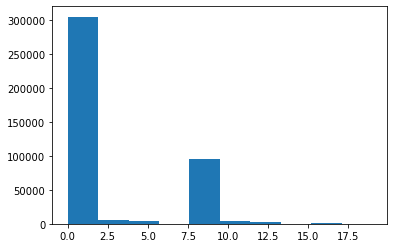

In [19]:
# Have a look at the distribution of target values, the data is heavily imbalanced
plt.hist(y_train_transformed)

In [20]:
# Helper function, used in building training and validating datasets
def build_datasets(data, target, train_size, valid_pct = 0.2, seed = None):
    x, x_fft = data # split the data in to raw and FFT data
    idx = np.arange(train_size) # Create a list of indexes
#     train_idx, val_idx = train_test_split(idx, test_size = valid_pct, random_state = seed)
    # Start spliting the data into training and validating parts using the validate percentage (valid_pct) value
    train_idx, val_idx = idx[round(train_size * valid_pct):], idx[:round(train_size * valid_pct)]
    # Build the train data, which include raw x, FFT x, and target y 
    train_ds = TensorDataset(torch.tensor(x[:train_size][train_idx]).float(),
                            torch.tensor(x_fft[:train_size][train_idx]).float(),
                            torch.tensor(target[:train_size][train_idx]).long())
    print("There are",len(set(target[:train_size][train_idx])),"class in training data")
    # Build the validating data, which include raw x, FFT x, and target y 
    val_ds = TensorDataset(torch.tensor(x[:train_size][val_idx]).float(),
                            torch.tensor(x_fft[:train_size][val_idx]).float(),
                            torch.tensor(target[:train_size][val_idx]).long())
    return train_ds, val_ds 

In [21]:
# Helper function, 
def build_loaders(data, batch_size = 128, jobs = 8):
    train_ds, valid_ds = data
    # Build a train dataloader
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = False, num_workers = jobs)
    # Build a test dataloader
    valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = jobs)
    return train_dl, valid_dl 

In [22]:
# https://www.kaggle.com/purplejester/pytorch-deep-time-series-classification
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

https://www.kaggle.com/purplejester/pytorch-deep-time-series-classification  

To design a classifier, we'll first develop a few of helper classes. There are no specialised SeparableConv layers in the torch framework. However, we can simply reproduce them using the following class. (This was taken from a topic on the PyTorch forum.)

In [23]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=False,
                 activ=lambda: nn.ReLU()):
    
        super().__init__()
        # Check the drop out rate
        assert drop is None or (0.0 < drop < 1.0)
        # Build a separable convolution layer, using channel_in, channel_out, kernel size, stride, and padding size 
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        # Add an activation function
        if activ:
            layers.append(activ())
        # Apply batch normalization if required
        if bn:
            layers.append(nn.BatchNorm1d(no))
        # Apply drop out rate to prevent the model from overfitting
        if drop is not None:
            layers.append(nn.Dropout(drop))
        # chain all of the layers into one object
        self.layers = nn.Sequential(*layers)
    
    # Define forward function
    def forward(self, x): 
        return self.layers(x)

In [24]:
# Helper function, used to build flatten layers
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim
    # Define forward function, which flatten the input into 1 dimension, or 2 dimension which is [batchsize, -1]
    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [25]:
# Helper function to print the shape of a layer's output, this function is useful when building and debugging 
# models
class PrintSize(nn.Module):
    def __init__(self):
        super(PrintSize, self).__init__()
        
    def forward(self, x):
        print(x.shape)
        return x

In [26]:
# model building, which includes 2 branches, one brach for raw input with 30 time steps, one branch for 
# FFT input with 30/2 + 1 = 16 timesteps.
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        #PKS [[4,8,2],[1,3,1],[3,8,2],[1,3,1],[5,8,2],[1,3,1],[2,8,2]]
        self.raw = nn.Sequential( 
            #         (in ,out ,kernel, stride, pad)
            SepConv1d(raw_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 3, drop=drop),
            SepConv1d(    64, 128, 8, 2, 5, drop=drop),
            SepConv1d(   128, 256, 8, 2, 2),
            Flatten(),
#             PrintSize(),
            nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True))
        #PKS [[3,8,2],[1,3,1],[5,8,2],[1,3,1],[4,8,2],[1,3,1],[3,8,2]]
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 2, 5, drop=drop),
            SepConv1d(    64, 128, 8, 2, 4, drop=drop),
            SepConv1d(   128, 128, 8, 2, 5, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
#             PrintSize(),
            nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
                
    # Define a forward function for the model
    def forward(self, t_raw, t_fft):
        # raw x branch
        raw_out = self.raw(t_raw)
        # fft x branch
        fft_out = self.fft(t_fft)
        # concat 2 branches into one
        t_in = torch.cat([raw_out, fft_out], dim=1)
        # push it through fully connected layers to get the output
        out = self.out(t_in)
        return out

In [27]:
# class Classifier(nn.Module):
#     def __init__(self, raw_ni, fft_ni, no, drop=.5):
#         super().__init__()
#         #PKS [[4,8,2],[3,8,2],[5,8,2],[2,8,2]]
#         self.raw = nn.Sequential( #kernel, stride, pad
#             SepConv1d(raw_ni,  32, 8, 2, 4, drop=drop),
#             SepConv1d(    32,  64, 8, 2, 3, drop=drop),
#             SepConv1d(    64, 128, 8, 2, 5, drop=drop),
#             SepConv1d(   128, 256, 8, 2, 2, drop=drop),
#             Flatten(),
# #             PrintSize(),
#             nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace=True),
#             nn.Dropout(drop), nn.Linear( 256, 64), nn.ReLU(inplace=True))
#         #PKS [3,8,2],[5,8,2],[4,8,2],[5,8,2],[3,8,2]
#         self.fft = nn.Sequential(
#             SepConv1d(fft_ni,  32, 8, 2, 3, drop=drop),
#             SepConv1d(    32,  64, 8, 2, 5, drop=drop),
#             SepConv1d(    64, 128, 8, 2, 4, drop=drop),
#             SepConv1d(   128, 128, 8, 2, 5, drop=drop),
#             SepConv1d(   128, 256, 8, 2, 3, drop=drop),
#             Flatten(),
# #             PrintSize(),
#             nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace=True),
#             nn.Dropout(drop), nn.Linear( 256, 64), nn.ReLU(inplace=True))
        
#         self.out = nn.Sequential(
#             nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
#     def forward(self, t_raw, t_fft):
#         raw_out = self.raw(t_raw)
#         fft_out = self.fft(t_fft)
#         t_in = torch.cat([raw_out, fft_out], dim=1)
#         out = self.out(t_in)
#         return out

In [28]:
# https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
# Helper function, implementation of focal loss in order to solve class imbalance problem
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [29]:
seed = 1
# Since we use the provided data for only training and validating, thus no testing data needed. Thus we set the 
# train size to the full length of x_train.
train_size = len(x_train)
# build data set with validation percentage = 10%
datasets = build_datasets((x_train, x_train_fft), y_train_transformed,
                          train_size = train_size, valid_pct = 0.1, seed=seed)

There are 20 class in training data


In [31]:
# Calculate the proportion of different classes in the data
cls_count = dict(collections.Counter(y_train_transformed)) # count the number of appearance per class
cls_weights = np.array([i[1] for i in sorted(cls_count.items())]) # sort the classes by descending order of class 
                                                                  # appearance count
cls_weights = torch.Tensor([1-cls_weights/np.sum(cls_weights)]) # calculate the proportions.
cls_weights = cls_weights.to(device) # Send the class weight to cuda device


In [30]:
# Set device for training, this model is trained on a RTX 3080, thus the device will be "cuda"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [ ]:
# Get the input number of features of the x_raw branch of the model, which is 30
raw_feat = x_train.shape[1]
# Get the input number of features of the x_fft branch of the model, which is 16
fft_feat = x_train_fft.shape[1]
# Get the train and validate dataloaders
trn_dl, val_dl = build_loaders(datasets, batch_size=512)

lr = 0.0002 # Set learning rate
n_epochs = 400 # Set maximum epoch
iterations_per_epoch = len(trn_dl) # Iteration per epoch
num_classes = 20 # Number of classes
best_acc = 0 # Set best accuracy for later early stopping purpose
best_f1 = 0 # Set best F1_score for later early stopping purpose
patience, trials = 400, 0 # Set patience and a counter for later early stopping purpose
base = 1 # use to efficiently print the loss and accuracy while training 
step = 2 # use to efficiently print the loss and accuracy while training, only print out the accuracy at
         # step 2,4,8,16,32,...
loss_history = [] # For loss storing
acc_history = [] # For accuracy storing
gstep = -1 # Global step - used to initiate an One Cycle Learning Rate Scheduler. gstep = -1 means entirely new model
model = Classifier(raw_feat, fft_feat, num_classes,drop = .5).to(device) # Create the CNN model 
# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = FocalLoss() # Create loss function
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay= 0.0001) # Initiate Adam optimizer
# Create a one cycle learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, 0.004, steps_per_epoch = iterations_per_epoch,
                                                   epochs = n_epochs, pct_start = 0.4,base_momentum = 0.85, 
                                                   max_momentum=0.95, div_factor = 10.0, last_epoch = gstep)
print('Start model training')

for epoch in range(1, n_epochs + 1):
    # Set model to traning mode
    model.train()
    epoch_loss = 0
    # Iterate through every batch of the train data loader
    for i, batch in enumerate(trn_dl):
        # Send the input to CUDA device
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw, x_fft) # Get the output from the model
        loss = criterion(out, y_batch) # Calculate losses
        epoch_loss += loss.item() # Record the loss
        loss.backward() # Back-propagation
        opt.step() # Call step() method to update the parameters
        lr_scheduler.step() # Call step() method to update the parameters
    # average the epoch's loss
    epoch_loss /= train_size
    # Record the loss history
    loss_history.append(epoch_loss)
    # Start validating
    model.eval()
    correct, total, epoch_f1 = 0, 0, []
    for batch in val_dl: # Iterate through every batch of the validating data
        # Send the data to CUDA device
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft) # Get the output from the model
        preds = F.log_softmax(out, dim=1).argmax(dim=1) # Generate final prediction
        # Calculate F1_score of the batch
        batch_f1 = f1_score(y_batch.detach().cpu().clone().numpy(), preds.detach().cpu().clone().numpy(), 
                           average="macro")
        epoch_f1.append(batch_f1) # Record the error
        total += y_batch.size(0) 
        correct += (preds == y_batch).sum().item() # calculate the accuracy
    # average the F1_score of all batches to get the validation F1_score
    cur_f1 = np.mean(epoch_f1)
    epoch_f1 = []
    # Get the validating accuracy   
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step
    # Keep track of the improvement of the model in term of accuracy for early stopping
    if acc > best_acc:
        trials = 0
        best_acc = acc
        # save the model with best accuracy
        torch.save(model.state_dict(), 'bestaccu.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    # Keep track of the improvement of the model in term of F1_score for early stopping
    if cur_f1 > best_f1:
        trials = 0
        best_f1 = cur_f1
        # save the model with best F1_score
        torch.save(model.state_dict(), 'bestf1.pth')
        print(f'Epoch {epoch} best F1 saved with F1: {best_f1:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 0.0006. Acc.: 56.85%
Epoch 1 best model saved with accuracy: 56.85%
Epoch 1 best F1 saved with F1: 29.62%
Epoch:   2. Loss: 0.0004. Acc.: 64.56%
Epoch 2 best model saved with accuracy: 64.56%
Epoch 2 best F1 saved with F1: 42.41%
Epoch:   4. Loss: 0.0002. Acc.: 83.41%
Epoch 4 best model saved with accuracy: 83.41%
Epoch 4 best F1 saved with F1: 66.22%


In [37]:
torch.save(model.state_dict(), 'latest.pth')
del x_train_rolled

# Inference

In [ ]:
# Delete redundant variables (optional)
del x_train,x_train_fft,x_train_rolled

In [ ]:
# Build a new classifier model
model = Classifier(10, 10, 20)
# load the state dict of the previously trained models
model.load_state_dict(torch.load("./bestaccu.pth"))

In [41]:
# change its mode to evaluating
model.eval()

Classifier(
  (raw): Sequential(
    (0): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(10, 10, kernel_size=(8,), stride=(2,), padding=(4,), groups=10)
          (pointwise): Conv1d(10, 32, kernel_size=(1,), stride=(1,))
        )
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (1): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(32, 32, kernel_size=(8,), stride=(2,), padding=(3,), groups=32)
          (pointwise): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (2): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(64, 64, kernel_size=(8,), stride=(2,), padding=(5,), groups=64)
          (pointwise): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
   

In [17]:
# Load the testing data
x_test = pd.read_csv("../FIT5149_A2_data/test_data_nolabels.csv")
x_test.rename(columns={'Unnamed: 0': 'id'}, inplace= 1) # Rename 
x_test['id'] = x_test['id'] + 28 # Increase the ID column by 28 for later rolling
x_test

id   load  hourofday dayofweek    dif  absdif    max       var  \
0           29  1.869          0       Mon  0.000   0.000  0.000  0.000000   
1           30  1.673          0       Mon -0.196   0.196  0.000  0.000000   
2           31  1.660          0       Mon -0.013   0.013  0.000  0.000000   
3           32  1.772          0       Mon  0.112   0.112  0.000  0.000000   
4           33  1.679          0       Mon -0.093   0.093  0.000  0.000000   
...        ...    ...        ...       ...    ...     ...    ...       ...   
105535  105564  1.076         23       Sat -0.001   0.001  6.204  2.484129   
105536  105565  1.019         23       Sat -0.057   0.057  6.215  2.614626   
105537  105566  1.014         23       Sat -0.005   0.005  6.215  2.729923   
105538  105567  1.011         23       Sat -0.003   0.003  6.215  2.868153   
105539  105568  1.258         23       Sat  0.247   0.247  6.215  2.972294   

         entropy  nonlinear     hurst  
0       0.000000   0.000000  0.000000  
1       0.000000   0.000000  0.000000  
2       0.000000   0.000000  0.000000  
3       0.000000   0.000000  0.000000  
4       0.000000   0.000000  0.000000  
...          ...        ...       ...  
105535  0.592658   0.042413  0.990185  
105536  0.601761   0.038118  0.990529  
105537  0.629122   0.048229  0.993554  
105538  0.658328   0.046729  0.993813  
105539  0.676443   0.049666  0.993965  

[105540 rows x 11 columns]

In [19]:
x_test.head(10000)

id   load  hourofday dayofweek           dif        absdif    max  \
0        29  1.869          0       Mon  0.000000e+00  0.000000e+00  0.000   
1        30  1.673          0       Mon -1.960000e-01  1.960000e-01  0.000   
2        31  1.660          0       Mon -1.300000e-02  1.300000e-02  0.000   
3        32  1.772          0       Mon  1.120000e-01  1.120000e-01  0.000   
4        33  1.679          0       Mon -9.300000e-02  9.300000e-02  0.000   
5        34  1.775          0       Mon  9.600000e-02  9.600000e-02  0.000   
6        35  1.759          0       Mon -1.600000e-02  1.600000e-02  0.000   
7        36  1.705          0       Mon -5.400000e-02  5.400000e-02  0.000   
8        37  1.829          0       Mon  1.240000e-01  1.240000e-01  0.000   
9        38  1.720          0       Mon -1.090000e-01  1.090000e-01  0.000   
10       39  1.676          0       Mon -4.400000e-02  4.400000e-02  0.000   
11       40  1.772          0       Mon  9.600000e-02  9.600000e-02  0.000   
12       41  1.646          0       Mon -1.260000e-01  1.260000e-01  0.000   
13       42  1.646          0       Mon  0.000000e+00  0.000000e+00  0.000   
14       43  3.033          0       Mon  1.387000e+00  1.387000e+00  0.000   
15       44  2.942          0       Mon -9.100000e-02  9.100000e-02  0.000   
16       45  2.940          0       Mon -2.000000e-03  2.000000e-03  0.000   
17       46  3.063          0       Mon  1.230000e-01  1.230000e-01  0.000   
18       47  2.837          0       Mon -2.260000e-01  2.260000e-01  0.000   
19       48  2.896          0       Mon  5.900000e-02  5.900000e-02  0.000   
20       49  2.875          0       Mon -2.100000e-02  2.100000e-02  0.000   
21       50  2.823          0       Mon -5.200000e-02  5.200000e-02  0.000   
22       51  2.949          0       Mon  1.260000e-01  1.260000e-01  0.000   
23       52  2.841          0       Mon -1.080000e-01  1.080000e-01  0.000   
24       53  2.726          0       Mon -1.150000e-01  1.150000e-01  0.000   
25       54  2.759          0       Mon  3.300000e-02  3.300000e-02  0.000   
26       55  2.892          0       Mon  1.330000e-01  1.330000e-01  0.000   
27       56  2.902          0       Mon  1.000000e-02  1.000000e-02  0.000   
28       57  3.057          0       Mon  1.550000e-01  1.550000e-01  0.000   
29       58  2.969          0       Mon -8.800000e-02  8.800000e-02  0.000   
30       59  2.994          0       Mon  2.500000e-02  2.500000e-02  3.148   
31       60  3.027          0       Mon  3.300000e-02  3.300000e-02  3.148   
32       61  3.028          0       Mon  1.000000e-03  1.000000e-03  3.148   
33       62  3.030          0       Mon  2.000000e-03  2.000000e-03  3.148   
34       63  3.148          0       Mon  1.180000e-01  1.180000e-01  3.148   
35       64  3.019          0       Mon -1.290000e-01  1.290000e-01  3.148   
36       65  3.005          0       Mon -1.400000e-02  1.400000e-02  3.148   
37       66  2.988          0       Mon -1.700000e-02  1.700000e-02  3.148   
38       67  3.123          0       Mon  1.350000e-01  1.350000e-01  3.148   
39       68  2.999          0       Mon -1.240000e-01  1.240000e-01  3.148   
40       69  2.997          0       Mon -2.000000e-03  2.000000e-03  3.148   
41       70  3.040          0       Mon  4.300000e-02  4.300000e-02  3.148   
42       71  3.077          0       Mon  3.700000e-02  3.700000e-02  3.148   
43       72  2.980          0       Mon -9.700000e-02  9.700000e-02  3.148   
44       73  2.986          0       Mon  6.000000e-03  6.000000e-03  3.148   
45       74  2.989          0       Mon  3.000000e-03  3.000000e-03  3.148   
46       75  3.038          0       Mon  4.900000e-02  4.900000e-02  3.148   
47       76  1.745          0       Mon -1.293000e+00  1.293000e+00  3.148   
48       77  1.697          0       Mon -4.800000e-02  4.800000e-02  3.148   
49       78  1.663          0       Mon -3.400000e-02  3.400000e-02  3.148   
50       79  1.534          0  

In [43]:
# Set the list of variables that will be scaled
scale_list = ['absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst', 'load', 'max', 'nonlinear', 'var']
# Use the label encoder of training data to encode the testing one
x_test[scale_list] = scaler.transform(x_test[scale_list]) # Perform scaling
x_test

id      load  hourofday  dayofweek       dif    absdif       max  \
0           29 -0.166969  -1.659524  -1.006070  0.000001 -0.315136 -1.866220   
1           30 -0.270641  -1.659524  -1.006070 -0.369164  0.071926 -1.866220   
2           31 -0.277518  -1.659524  -1.006070 -0.024484 -0.289464 -1.866220   
3           32 -0.218276  -1.659524  -1.006070  0.210953 -0.093958 -1.866220   
4           33 -0.267468  -1.659524  -1.006070 -0.175164 -0.131479 -1.866220   
...        ...       ...        ...        ...       ...       ...       ...   
105535  105564 -0.586420   1.664007  -0.506444 -0.001882 -0.313161  1.044964   
105536  105565 -0.616570   1.664007  -0.506444 -0.107358 -0.202572  1.050126   
105537  105566 -0.619215   1.664007  -0.506444 -0.009416 -0.305262  1.050126   
105538  105567 -0.620802   1.664007  -0.506444 -0.005649 -0.309212  1.050126   
105539  105568 -0.490153   1.664007  -0.506444  0.465225  0.172641  1.050126   

             var   entropy  nonlinear      hurst  
0      -1.046775 -7.500160  -0.562601 -14.864864  
1      -1.046775 -7.500160  -0.562601 -14.864864  
2      -1.046775 -7.500160  -0.562601 -14.864864  
3      -1.046775 -7.500160  -0.562601 -14.864864  
4      -1.046775 -7.500160  -0.562601 -14.864864  
...          ...       ...        ...        ...  
105535  0.342846 -1.219789  -0.546356   0.266524  
105536  0.415846 -1.123327  -0.548001   0.271783  
105537  0.480343 -0.833378  -0.544128   0.317999  
105538  0.557669 -0.523885  -0.544702   0.321967  
105539  0.615926 -0.331925  -0.543578   0.324291  

[105540 rows x 11 columns]

In [44]:
# Since the design choice is to use 30 minutes at each time-step, therefore each of the first 29 observations 
# will not have enough 29 observations before it in order to create a series of 30 observations.
# Thus I will add 29 copies of the first observation to the top of the testing dataframe.
extra_len = pd.DataFrame(x_test.iloc[0:1,:].values.repeat(29, axis = 0), columns=x_test.columns)
extra_len['id'] = list(range(0,29))

# concatenate the testing and the additional data
x_test = pd.concat([extra_len, x_test])
x_test['dummy_id'] = 1 # Create a dummy ID column for rolling
x_test.reset_index(drop= True, inplace=True) # Reset index
x_test.head(100)

id      load  hourofday  dayofweek       dif    absdif       max  \
0    0 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
1    1 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
2    2 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
3    3 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
4    4 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
5    5 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
6    6 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
7    7 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
8    8 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
9    9 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
10  10 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
11  11 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
12  12 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
13  13 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
14  14 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
15  15 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
16  16 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
17  17 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
18  18 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
19  19 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
20  20 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
21  21 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
22  22 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
23  23 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
24  24 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
25  25 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
26  26 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
27  27 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
28  28 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
29  29 -0.166969  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
30  30 -0.270641  -1.659524   -1.00607 -0.369164  0.071926 -1.866220   
31  31 -0.277518  -1.659524   -1.00607 -0.024484 -0.289464 -1.866220   
32  32 -0.218276  -1.659524   -1.00607  0.210953 -0.093958 -1.866220   
33  33 -0.267468  -1.659524   -1.00607 -0.175164 -0.131479 -1.866220   
34  34 -0.216689  -1.659524   -1.00607  0.180817 -0.125554 -1.866220   
35  35 -0.225152  -1.659524   -1.00607 -0.030135 -0.283539 -1.866220   
36  36 -0.253715  -1.659524   -1.00607 -0.101707 -0.208496 -1.866220   
37  37 -0.188126  -1.659524   -1.00607  0.233555 -0.070260 -1.866220   
38  38 -0.245781  -1.659524   -1.00607 -0.205300 -0.099882 -1.866220   
39  39 -0.269055  -1.659524   -1.00607 -0.082872 -0.228244 -1.866220   
40  40 -0.218276  -1.659524   -1.00607  0.180817 -0.125554 -1.866220   
41  41 -0.284923  -1.659524   -1.00607 -0.237319 -0.066310 -1.866220   
42  42 -0.284923  -1.659524   -1.00607  0.000001 -0.315136 -1.866220   
43  43  0.448721  -1.659524   -1.00607  2.612409  2.423922 -1.866220   
44  44  0.400587  -1.659524   -1.00607 -0.171397 -0.135429 -1.866220   
45  45  0.399530  -1.659524   -1.00607 -0.003766 -0.311186 -1.866220   
46  46  0.464590  -1.659524   -1.00607  0.231671 -0.072235 -1.866220   
47  47  0.345048  -1.659524   -1.00607 -0.425669  0.131170 -1.866220   
48  48  0.376256  -1.659524   -1.00607  0.111128 -0.198622 -1.866220   
49  49  0.365148  -1.659524   -1.00607 -0.039552 -0.273665 -1.866220   
50  50  0.337643  -1.659524   -1.00607 -0.097940 -0.212446 -1.866220   
51  51  0.404290  -1.659524   -1.00607  0.237322 -0.066310 -1.866220   
52  52  0.347164  -1.659524   -1.00607 -0.203416 -0.101857 -1.866220   
53  53  0.286336  -1.659524   -1.00607 -0.216601 -0.088033 -1.866220   
54  54  0.303791  -1.659524   -1.00607  0.06

In [ ]:
# roll_time_series method creates sub windows of the time series. It rolls the (sorted) data frames for each 
# kind and each id separately in the “time” domain (which is represented by the sort order of the sort column given
# by column_sort).
# For example when applying the roll_time_series to a data [a,b,c,d,e,f,g] with time_shift = 3, the result will be 
# [a,b,c, b,c,d, c,d,e, d,e,f, e,f,g]. The input of the CNN model will have a shape of [30,10] (30 timestep, 10
# variables) and its prediction will be the appliances status at time_step 30.
# Notice: run these 3 lines of code will take hours


# x_test_rolled = roll_time_series(x_test, column_id="dummy_id", column_sort="id",
#                             max_timeshift = 29, min_timeshift = 29)
# np.save("../np_x_test_rolled.npy",np.array(x_test_rolled))

In [45]:
x_test_rolled = np.load('../np_x_test_rolled.npy', allow_pickle= True)
x_test_rolled = pd.DataFrame(x_test_rolled, columns=x_test.columns)
x_test_rolled = x_test_rolled[['id', 'load', 'absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst', 
        'max', 'nonlinear', 'var','dummy_id']]

In [46]:
x_test_rolled.head(100)

id      load    absdif dayofweek       dif  entropy hourofday  \
0   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
1   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
2   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
3   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
4   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
5   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
6   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
7   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
8   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
9   (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
10  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
11  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
12  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
13  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
14  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
15  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
16  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
17  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
18  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
19  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
20  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
21  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
22  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
23  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
24  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
25  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
26  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
27  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
28  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
29  (1, 29) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
30  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
31  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
32  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
33  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
34  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
35  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
36  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
37  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
38  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
39  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
40  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
41  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
42  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
43  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
44  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
45  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
46  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
47  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
48  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
49  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
50  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
51  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
52  (1, 30) -0.166969 -0.315136  -1.00607  0.000001 -7.50016 -1.659524   
53  (1, 30) -

In [47]:
# check if there're any shape differences between rolled data and original data
print(len(x_test_rolled)/30)
print(len(x_test)-29)

105540.0
105540


In [48]:
# Drop the ID and dummy_id columns
x_test_rolled.drop(['id','dummy_id'], axis=1, inplace=True)
# reshape the rolled x_train to a new shape of [105540,30,10]
x_test_rolled = np.reshape(x_test_rolled.to_numpy(dtype=np.float64), [-1 , 30, int(x_test_rolled.shape[1])])
x_test_rolled.shape

(105540, 30, 10)

In [49]:
# https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html
# Compute the one-dimensional discrete Fourier Transform for real input.
# This function computes the one-dimensional n-point discrete Fourier Transform (DFT)
# of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).
x_test_fft = np.copy(x_test_rolled)
x_test_fft = np.apply_along_axis(absfft, 1, x_test_fft)
x_test_fft

array([[[5.00905621e+00, 9.45408046e+00, 3.01820915e+01, ...,
         5.59866143e+01, 1.68780394e+01, 3.14032524e+01],
        [0.00000000e+00, 0.00000000e+00, 1.24860292e-15, ...,
         2.49720583e-15, 0.00000000e+00, 0.00000000e+00],
        [6.34815699e-17, 0.00000000e+00, 5.07852559e-16, ...,
         1.01570512e-15, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.34934242e-17, 0.00000000e+00, 1.07947394e-16, ...,
         2.15894788e-16, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.31233455e-16, ...,
         2.62466909e-16, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.11272906e+00, 9.06701819e+00, 3.01820915e+01, ...,
         5.59866143e+01, 1.68780394e+01, 3.14032524e+01],
        [1.03672855e-01, 3.87062265e-01, 1.24860292e-15, ...,
         2.49720583e-15, 0.00000000e+00, 0.00000000e+00],
        [1.03672855e-01, 

In [50]:
print(x_test_rolled.shape)
print(x_test_fft.shape)

(105540, 30, 10)
(105540, 16, 10)


In [52]:
# Transpose the shape x_test and x_test_fft to [observations, features, time_steps]
x_test = x_test_rolled.transpose(0,2,1)
x_test_fft = x_test_fft.transpose(0,2,1)

In [53]:
print(x_test.shape)
print(x_test_fft.shape)

(105540, 10, 30)
(105540, 10, 16)


In [54]:
# Set the preferred device for testing to CPU

# device_test = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_test = torch.device('cpu')

In [55]:
# Get the testing dataset
test_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(x_test_fft).float())
# Get the testing dataloader
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

test_preds = [] # to store prediction

In [57]:
# Change the model mode to evaluate and send to the device
model.eval()
model.to(device_test)

Classifier(
  (raw): Sequential(
    (0): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(10, 10, kernel_size=(8,), stride=(2,), padding=(4,), groups=10)
          (pointwise): Conv1d(10, 32, kernel_size=(1,), stride=(1,))
        )
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (1): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(32, 32, kernel_size=(8,), stride=(2,), padding=(3,), groups=32)
          (pointwise): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (2): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(64, 64, kernel_size=(8,), stride=(2,), padding=(5,), groups=64)
          (pointwise): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
   

In [58]:
# Perform predicting on testing date
for test_batch in tqdm(test_dl): # Iterate through every batch of testing dataloader
    x_raw, x_fft = [t.to(device_test) for t in test_batch] # Send the data to device
    out = model(x_raw, x_fft) # Get the output
    preds = F.log_softmax(out, dim=1).argmax(dim=1) # Get the final prediction
    # decode its value for submisson compatability
    decoded_preds = le_y.inverse_transform([preds.detach().cpu().clone().numpy()]) 
    # Save the prediction
    test_preds.append([i for i in decoded_preds[0]])

  0%|          | 0/105540 [00:00<?, ?it/s]/home/starlet/anaconda3/envs/spconv12cuda11/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████| 105540/105540 [03:17<00:00, 534.92it/s]


In [59]:
# Convert the prediction list to dataframe
predictions = pd.DataFrame(np.array(test_preds)).reset_index()
predictions.columns = ['id', 'ac', 'ev', 'oven', 'wash', 'dryer'] # Add column names
predictions['id'] = predictions['id'] + 1 # For submission compatability
predictions.set_index('id',inplace=True) # set ID column as index
predictions.head() #have a look to check its format

ac ev oven wash dryer
id                          
1       0  0    0    0     0
2       0  0    0    0     0
3       0  0    0    0     0
4       0  0    0    0     0
5       0  0    0    0     0
...    .. ..  ...  ...   ...
105536  0  0    0    0     0
105537  0  0    0    0     0
105538  0  0    0    0     0
105539  0  0    0    0     0
105540  0  0    0    0     0

[105540 rows x 5 columns]

In [60]:
# Check how many classes are predicted
predictions[['ac', 'ev', 'oven', 'wash', 'dryer']].drop_duplicates()

ac ev oven wash dryer
id                       
1    0  0    0    0     0
137  1  0    0    0     0

In [61]:
# Export to .csv file for submission
predictions.to_csv('../CNN_predictions.csv')

In [ ]:
out.detach().cpu()
y_batch.detach().cpu()

In [ ]:
y_train_transformed

In [ ]:
cls_count = dict(collections.Counter(y_train_transformed))

In [ ]:
cls_weights = np.array([i[1] for i in sorted(cls_count.items())])

In [ ]:
cls_weights = torch.Tensor([cls_weights/np.sum(cls_weights)])
cls_weights

In [ ]:
cls_weights.shape

In [ ]:
cls_weights_test = torch.Tensor([cls_weights[0],1-cls_weights[0]])
cls_weights_test

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
temp_loss = FocalLoss(gamma=2, reduction='sum', weight=cls_weights)

In [ ]:
temp_loss(out, y_batch)

In [ ]:
out

In [ ]:
y_batch

In [ ]:
torch.randn(3, 5, requires_grad=True)

In [ ]:
torch.randint(5, (3,), dtype=torch.int64)

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)
loss

In [ ]:
def prepare_loss_weights(labels,
                         pos_cls_weight=1.0,
                         neg_cls_weight=1.0,
                         loss_norm_type='norm_by_num_positives',
                         dtype=torch.float32):
    """get cls_weights and reg_weights from labels.
    """
    cared = labels >= 0
    # cared: [N, num_anchors]
    positives = labels > 0
    negatives = labels == 0
    negative_cls_weights = negatives.type(dtype) * neg_cls_weight
    cls_weights = negative_cls_weights + pos_cls_weight * positives.type(dtype)
    reg_weights = positives.type(dtype)
    pos_normalizer = positives.sum(1, keepdim=True).type(dtype)
    reg_weights /= torch.clamp(pos_normalizer, min=1.0)
    cls_weights /= torch.clamp(pos_normalizer, min=1.0)

    return cls_weights, reg_weights, cared

In [ ]:
prepare_loss_weights(torch.Tensor([y_train_transformed]))

In [ ]:
test = np.load('./np_x_train_rolled_new.npy', allow_pickle= True)

In [ ]:
np.array(test,dtype = np.float64)

In [ ]:
x_train_rolled.to_numpy(dtype=np.float64).dtype

In [ ]:
np.vstack(x_train_rolled[:, 0:1]).astype(np.float)


In [ ]:
x_train_rolled.drop('id', axis=1, inplace=True)
x_train_rolled

In [ ]:
y_train.shape

In [ ]:
# x_train_rolled = pd.concat([roll_time_series(temp, column_id="dummy_id", column_sort="id",
#             max_timeshift = 29, min_timeshift = 29),x_train_rolled]).reset_index(drop = True)

In [ ]:
# np.save("np_x_train_rolled_new.npy",np.array(x_train_rolled))

In [ ]:
print(x_train)

In [ ]:
# x_train.drop(x_train.index[0:29])
x_train.head(100)

In [ ]:
# 

## no need now - additional features calculators 

In [ ]:
x_features = extract_features(x_train_rolled.loc[0:299999],column_id='id',column_sort='ids', 
                 default_fc_parameters=EfficientFCParameters())

In [ ]:
x_features.shape

In [ ]:
len(x_train_rolled.loc[0:299999,'id'].value_counts())

In [ ]:
from tsfresh.feature_selection.significance_tests import target_real_feature_real_test
x_features_dropped = x_features.dropna(axis=1, how='any')
keeps = {}
for col in x_features_dropped.columns:
    p_value = target_real_feature_real_test(x_features_dropped[col].reset_index().drop(columns=["level_0","level_1"],
                                                                       axis = 1).squeeze(), 
                                     pd.Series(y_train_transformed[29:(29+60130)]))
    if p_value < 0.01:
        keeps[col] = p_value

In [ ]:
best_features = sorted(list(dict(sorted(keeps.items(), key=lambda item: item[1])).keys())[:255])
x_features = x_features[best_features]

In [ ]:
x_features['ids'] = x_features.index
x_train_rolled_temp = x_train_rolled.loc[0:299999]

In [ ]:
x_train_temp = x_train_rolled_temp.merge(x_features, how='left', left_on="id", right_on="ids")

In [ ]:
x_features

In [ ]:
x_minimal = extract_features(x_train_rolled.loc[0:299999],column_id='id',column_sort='ids', 
                             default_fc_parameters=MinimalFCParameters())
x_minimal.shape

In [ ]:
len(y_train_transformed)

In [ ]:
tsfresh.feature_selection.significance_tests.target_real_feature_real_test(x_minimal['load__standard_deviation'].reset_index().drop(columns=["level_0","level_1"], axis = 1).squeeze(), 
                                                                               pd.Series(y_train_transformed[29:(29+60130)]))

In [ ]:
x_minimal.head(10000)

In [ ]:
pd.set_option('display.max_rows', 10000)
data.head(10000)

In [ ]:
pd.reset_option('all')

In [ ]:
l = FocalLoss(alpha=0.25, gamma=2.0)

In [ ]:
data.columns

In [ ]:
y_batch

In [ ]:
y_train.encoded.unique()

In [ ]:
criterion(out, torch.tensor([1]))

In [15]:
l = 33
pks = [[4,8,1],[2,8,2],[3,8,2],[3,8,2],[3,8,2]]
for i, layer in enumerate(pks):
    p,k,s = layer
    l = (l + 2*p - k)/s + 1
    print(f"length: {l}")

length: 34.0
length: 16.0
length: 8.0
length: 4.0
length: 2.0


In [9]:
l = 64
pks = [[3,8,2],[3,8,2],[3,8,2],[3,8,2],[3,8,2]]
for i, layer in enumerate(pks):
    p,k,s = layer
    l = (l + 2*p - k)/s + 1
    print(f"length: {l}")

length: 32.0
length: 16.0
length: 8.0
length: 4.0
length: 2.0


In [ ]:
l = 30
pks = [[4,8,2],[1,3,1],[3,8,2],[1,3,1],[5,8,2],[1,3,1],[2,8,2]]
for i, layer in enumerate(pks):
    p,k,s = layer
#     w = (w + 2*p - k)/s + 1
#     h = (h + 2*p - k)/s + 1
    l = (l + 2*p - k)/s + 1
    print(f"length: {l}")

In [ ]:
l = 16
pks = [[3,8,2],[1,3,1],[5,8,2],[1,3,1],[4,8,2],[1,3,1],[3,8,2]]
for i, layer in enumerate(pks):
    p,k,s = layer
#     w = (w + 2*p - k)/s + 1
#     h = (h + 2*p - k)/s + 1
    l = (l + 2*p - k)/s + 1
    print(f"length: {l}")

In [ ]:
        #PKS [[4,8,2],[3,8,2],[5,8,2],[2,8,2]]
        self.raw = nn.Sequential( #kernel, stride, pad
            SepConv1d(raw_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 3, drop=drop),
            SepConv1d(    64, 128, 8, 2, 5, drop=drop),
            SepConv1d(   128, 256, 8, 2, 2, drop=drop),
            Flatten(),
#             PrintSize(),
            nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 256, 64), nn.ReLU(inplace=True))
        #PKS [3,8,2],[5,8,2],[4,8,2],[5,8,2],[3,8,2]

In [ ]:
count_hourly = x_train.loc[:,:].groupby(["dayofweek",'hourofday']).count()
count_hourly.reset_index(inplace=True)

In [ ]:
count_hourly

In [ ]:
x_train.sort_values(by=["dayofweek",'hourofday']).head(1000)

In [ ]:
x_train = x_train.sort_values(by=["dayofweek",'hourofday'])

In [ ]:
x_train[(x_train.dayofweek == "Fri") & (x_train.hourofday == 11)].first_valid_index()

In [ ]:
min_hourly_obs = min(count_hourly['var'].values) 
drop_idx = []
for _, row in count_hourly.iterrows():
    drop_idx = [*drop_idx,*x_train[(x_train.dayofweek == row[0]) & (x_train.hourofday == row[1])].index.values[0:row[2] - min_hourly_obs]]
drop_idx

In [ ]:
x_train.drop(index = drop_idx, inplace = True)
x_train.loc[:,:].groupby(["dayofweek",'hourofday']).count()

In [ ]:
x_train

In [ ]:
a = [123]
b = list(range(1,4))
a + b

In [ ]:
min_hourly_obs

In [ ]:
df = pd.DataFrame({
   "id": [1, 1, 1, 1, 2, 2],
   "time": [1, 2, 3, 4, 8, 9],
   "x": [1, 2, 3, 4, 10, 11],
   "y": [5, 6, 7, 8, 12, 13],
})

In [ ]:
x_train.shape

In [ ]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(x_train[['load','dummy_id','id']], column_id="dummy_id", column_sort="id",
                            max_timeshift = 29, min_timeshift = 29)
df_rolled

In [ ]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(df, column_id="id", column_sort="time", max_timeshift=2, min_timeshift=2)
df_rolled

In [ ]:
from tsfresh import extract_features
df_features = extract_features(df_rolled, column_id="id", column_sort="time", )


In [ ]:
df_features

In [ ]:
x_train.loc[0:500, ['load','dummy_id','id']]